# Boosted Trees and Neural nets

In this section, we review two important classes of non-linear forecasting models: boosted trees and the multi-layer perceptron.

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

import numpy as np
import pandas as pd
from IPython.display import Image, display
from skfin.backtesting import Backtester
from skfin.datasets_ import load_kf_returns
from skfin.metrics import sharpe_ratio
from skfin.mv_estimators import MeanVariance
from skfin.plot import heatmap, line
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

logging.getLogger("skfin.datasets_").setLevel(logging.CRITICAL)

returns_data = load_kf_returns(cache_dir="data")
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]

INFO:skfin.dataloaders.cache:Loading from cache : data/12_Industry_Portfolios


## Boosted Trees

We first discuss boosted trees, in particular as described by the companion paper to the package `xgboost`: 

> Chen and Guestrin (2016): "XGBoost: A Scalable Tree Boosting System," *Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining.*

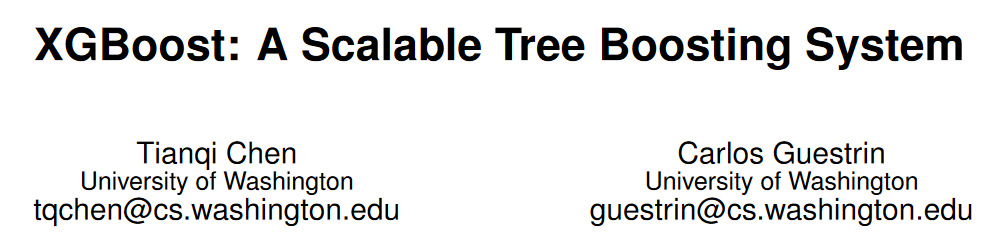

In [2]:
# hide
display(Image("images/xgboost_1.png", width=500))

For a dataset $\langle x_n, y_n \rangle$ with $N$ samples ($x_n \in \mathbb{R}^M$), a tree ensemble model uses $K$ additive functions: 

$$ \hat{y}_n = \phi(x_n) = \sum_k f_k(x_n),  $$ 

where $f_k$ is in the space of regression trees $\mathcal {F} = \{ f \}$: 

- $q$: $\mathbb{R}^M \rightarrow J$ is a partition; 
- $f(x) = w_{q(x)}$ is a constant value on each leaf of the tree. 

The objective is to minimize the loss: 

$$ \mathcal{L}(\phi) = \sum_n l(y_n, \hat{y}_n) + \sum_k \Omega(f_k),$$

where $\Omega(f) = \gamma J + \frac{1}{2}\lambda || w ||^2$ is a regularisation term and $l$ is a convex loss function (e.g. mean squared error). 

The functions $f_k$ are derived iteratively: 

$$ \mathcal {L}^k =  \sum_n l \left(y_n, \hat{y}^{k-1}_n + f_k(x_n) \right) + \Omega (f_k).$$

With a second-order Taylor expansion, we have 

$$ \mathcal {L}^k \approx \sum_n \left[ l (y_n, \hat{y}^{k-1}_n) + g_n f_k(x_n) + \frac{1}{2} h_n f_k(x_n)^2 \right] + \Omega (f_k), $$

where $g_n = \partial_{\hat{y}} l(y_n, \hat{y}^{k-1}_n)$ and $h_n = \partial^2 _{\hat{y}} l(y_n, \hat{y}^{k-1}_n)$. For an instance of leaf $j$, with $I_j = \{n| q(x_n)= j \}$, we can sum by leaf: 

$$ \mathcal {L}^{k} = \sum_{j=1}^{j=J} \left(\sum_{n \in I_j} g_n \right) w_j + \frac{1}{2} \left(\sum_{n \in I_j} h_n + \lambda \right) w_j^2 + \gamma J + constant. $$

For a given $q(x)$, the optimal weight $w_j^*$ of leaf $j$ is 

$$ w^*_j = - \frac{ \sum_{n \in I_j} g_n }{\sum_{n \in I_j} h_n + \lambda}. $$

The corresponding optimal value is then

$$\tilde{\mathcal{L}}^k (q) = - \frac{1}{2} \sum_{j=1}^{j=J} \frac{\left( \sum_{n \in I_j} g_n \right)^2 }{\sum_{n \in I_j} h_n + \lambda} + \gamma J + constant. $$

A greedy algorithm that starts from a single leaf and iteratively adds branches to the tree is used to dermine $q$. 

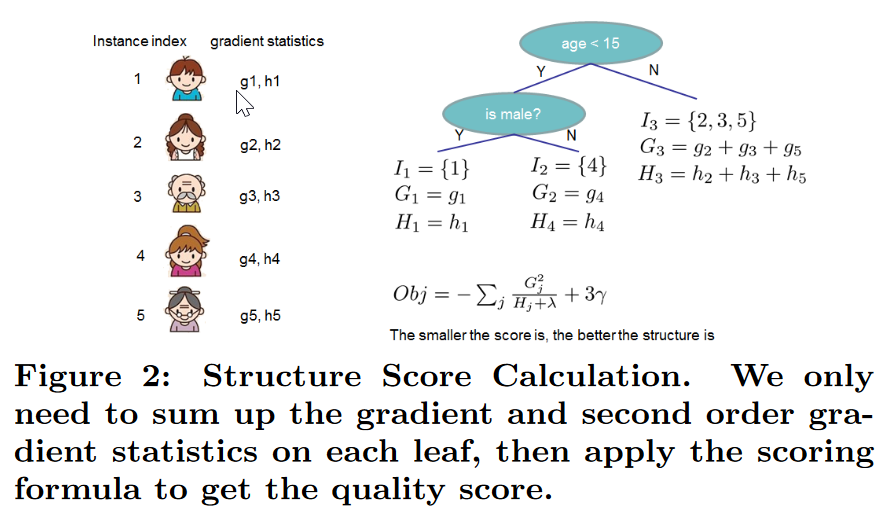

In [3]:
# hide
display(Image("images/xgboost_3.png", width=500))

In practice, `xgboost` (and `lightgbm`) can be used with custom loss functions -- for instance, by providing the gradient and hessian functions. 

## Multi-layer perceptron 

For the input $x \in \mathbb{M}$, the layer (with hidden size equals to $K$) of a multi-layer perceptron is given by 

$$g(b + W x)$$

where $W$ is a $[K \times M]$ matrix, $b$ is a scalar and $g$ is an activation function. The output of the last layer has to match the size of the target vector $y$. 

## Predicting industry returns with non-linear models

### Lightgbm

In [4]:
from skfin.estimators import MLPRegressor, MultiLGBMRegressor, Ridge


def transform_X(df, window=12):
    return df.rolling(window=window).mean()


def transform_y(df):
    return df.shift(-1)


features = transform_X(ret)
target = transform_y(ret)

As a benchmark based on estimating the cross-industry effects, we first look at the `Ridge` estimator.

In [5]:
%%time
estimator0 = make_pipeline(StandardScaler(with_mean=False), Ridge(), MeanVariance())
m = (
    Backtester(estimator0, name="Ridge (benchmark)")
    .compute_holdings(features, target)
    .compute_pnl(ret)
)
h0, pnl0, estimators0 = m.h_, m.pnl_, m.estimators_
pnls = [pnl0]

CPU times: user 2.71 s, sys: 5.13 s, total: 7.84 s
Wall time: 985 ms


In [6]:
estimator = make_pipeline(
    MultiLGBMRegressor(min_child_samples=5, n_estimators=25), MeanVariance()
)

CPU times: user 1min 33s, sys: 3min 31s, total: 5min 4s
Wall time: 38.4 s


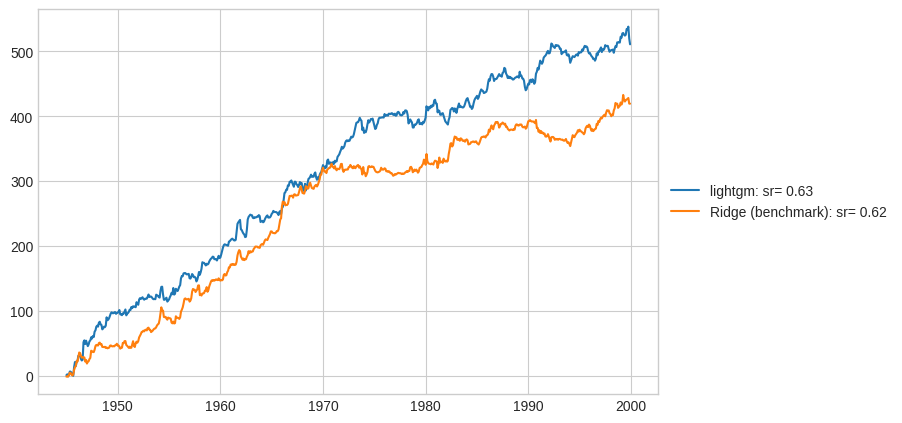

In [7]:
%%time
m = (
    Backtester(estimator, name="lightgm")
    .compute_holdings(features, target)
    .compute_pnl(ret)
)
pnls += [m.pnl_]
line(pnls, cumsum=True)

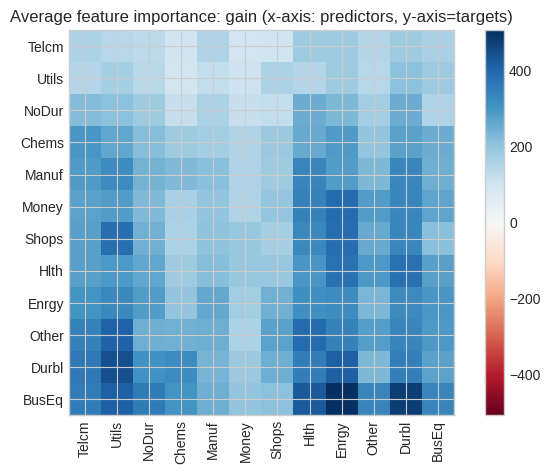

In [8]:
func = lambda x: np.stack(
    [m.booster_.feature_importance(importance_type="gain") for m in x]
)
importance = [func(m_.steps[0][1].m.estimators_) for m_ in m.estimators_]
importance_mean = pd.DataFrame(
    sum(importance) / len(importance), ret.columns, ret.columns
).T

heatmap(
    importance_mean.loc[
        importance_mean.mean().sort_values().index,
        importance_mean.mean().sort_values().index,
    ],
    title="Average feature importance: gain (x-axis: predictors, y-axis=targets)",
)

### MLPRegressor 

We first focus on a single window to understand how the `MLPRegressor` works in `scikit-learn`. 

In [9]:
for train, test in m.cv_.split(ret):
    break

In [10]:
scaler = StandardScaler(with_mean=True)
X_train = scaler.fit_transform(features.iloc[train])
y_train = target.iloc[train]

In [11]:
X_test = scaler.transform(features.iloc[test])
y_test = target.iloc[test]

We instantiate a simple `MLP` with 6 neurons. The activation function is a logistic sigmoid. 

In [12]:
m = MLPRegressor(
    hidden_layer_sizes=(6,),
    solver="adam",
    learning_rate_init=0.5,
    alpha=100,
    activation="logistic",
    tol=1e-2,
    n_iter_no_change=25,
    early_stopping=False,
)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)

When `early_stopping` is `False`, the optimisation stops based on the in-sample score, while when `early_stopping` is `True`, 
the decision to stop is based on a random sample (e.g. 10% of the training data).

In [13]:
print(f"The number of iterations is {m.n_iter_} (out of a maximum of {m.max_iter}).")

The number of iterations is 82 (out of a maximum of 200).


In [14]:
print(
    f"Number of parameter:\n - first layer: {12 * 6 + 6}\n - second layer: {12 * 6 + 12}\n - total number of parameters: {12 * 12 + 6 + 12}"
)

Number of parameter:
 - first layer: 78
 - second layer: 84
 - total number of parameters: 162


In [15]:
m.coefs_[0].shape, m.coefs_[1].shape

((12, 6), (6, 12))

In [16]:
m.intercepts_[0].shape, m.intercepts_[1].shape

((6,), (12,))

The `sigmoid logistic` activation function is also known as `expit` and it is provided by the `scipy` package. 

The MLP regressor in this case: 

- project the vector of size 12 on a vector of size 6
- a bias vector of size 6 is added
- the activitation function (here the `sigmoid`) regularizes the neurons
- the second layer then projects the vector of size 6 on a vector of size 12 (with a bias of size 12). 

In [17]:
from scipy.special import expit

y_pred_ = (
    expit(X_test.dot(m.coefs_[0]) + m.intercepts_[0]).dot(m.coefs_[1])
    + m.intercepts_[1]
)

In [18]:
np.allclose(y_pred, y_pred_)

True

The `sklearn` package provides a loss curve

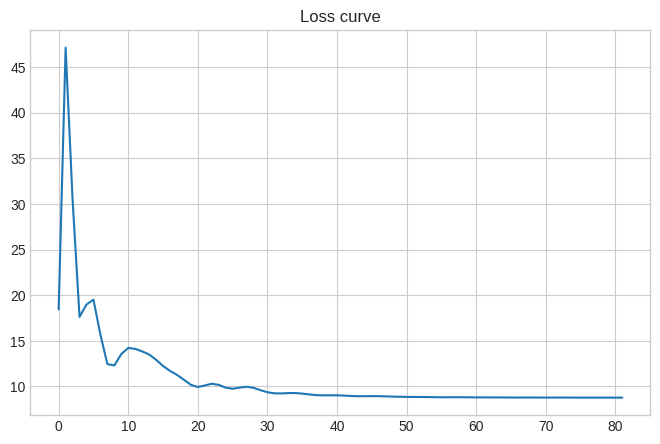

In [19]:
line(pd.Series(m.loss_curve_), legend=False, title="Loss curve")

The quadratic loss of is the `squared error`: 

In [20]:
np.allclose(m.loss_curve_[-1], ((y_train - y_pred) ** 2).mean().mean() / 2, atol=1e-2)

True

We now look at a backtest using `MLPRegressor`.

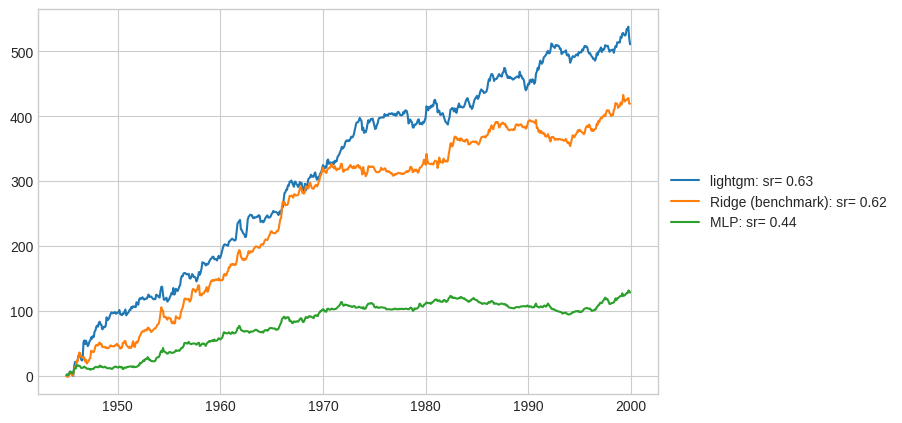

In [21]:
estimator = make_pipeline(
    StandardScaler(with_mean=False),
    MLPRegressor(
        hidden_layer_sizes=(6,),
        learning_rate_init=0.5,
        alpha=100,
        solver="adam",
        activation="logistic",
        tol=1e-2,
        n_iter_no_change=25,
        early_stopping=False,
    ),
    MeanVariance(),
)
m = (
    Backtester(estimator, name="MLP")
    .compute_holdings(features, target)
    .compute_pnl(ret)
)
pnls += [m.pnl_]

line(pnls, cumsum=True)

The graph below shows the number of iteration in the `Adam` stochastic gradient descent of the MLP estimator. While the MLP has no fixed number of iterations, it oscillates around 80. 

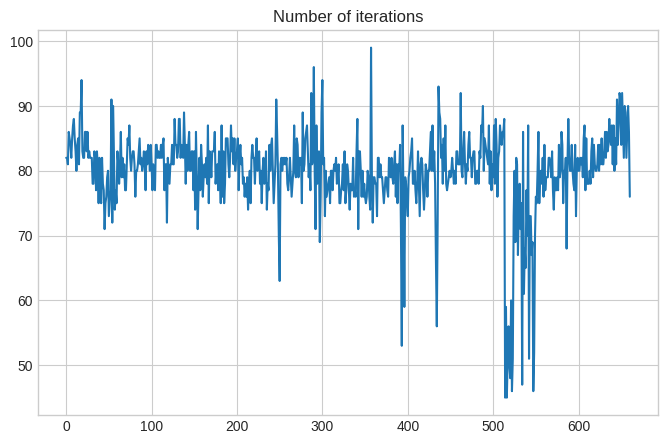

In [22]:
line(
    pd.Series([m_[1].n_iter_ for m_ in m.estimators_]),
    title="Number of iterations",
    legend=False,
)

The heatmaps below shows the coefficients $W$ for the first and second layers of the MLP. 

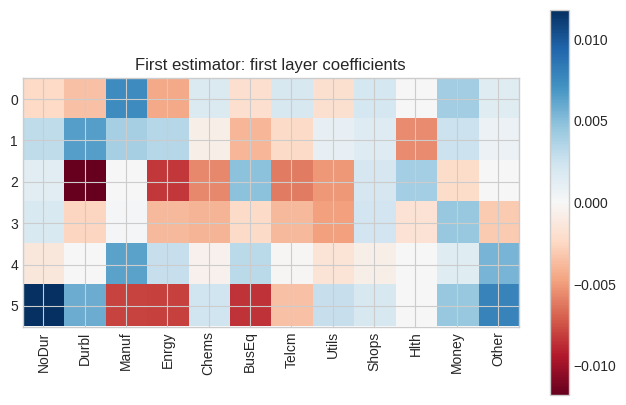

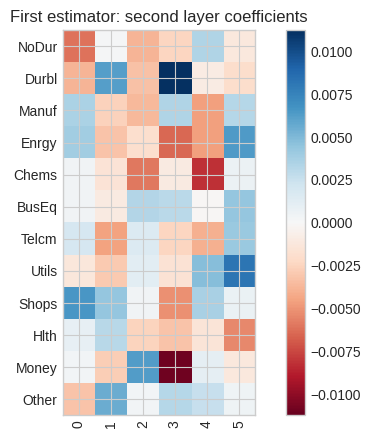

In [23]:
for m_ in m.estimators_:
    break

heatmap(
    pd.DataFrame(m_[1].coefs_[0], index=ret.columns),
    title="First estimator: first layer coefficients",
)
heatmap(
    pd.DataFrame(m_[1].coefs_[1], columns=ret.columns),
    title="First estimator: second layer coefficients",
)

Given the stochasticity of the estimation, we are interested in evaluating the noise associated to a given run. More precisely, we re-run the backtest with exactly the same estimator (and hence the same parameters). In fact, such stochasticity depends on the amount regularisation, and to make this point, we relax it with `alpha=50` (instead of 100).

In [24]:
%%time
estimator_ = make_pipeline(
    StandardScaler(with_mean=False),
    MLPRegressor(
        hidden_layer_sizes=(6,),
        learning_rate_init=0.5,
        alpha=50,
        n_iter_no_change=25,
        solver="adam",
        tol=1e-2,
        activation="logistic",
    ),
    MeanVariance(),
)
n_iter = 10
pnls_ = {}
for i in range(n_iter):
    pnls_[i] = Backtester(estimator_).train(features, target, ret)

sr_std = np.std([v.pipe(sharpe_ratio) for k, v in pnls_.items()])

CPU times: user 4min 50s, sys: 9min 21s, total: 14min 11s
Wall time: 1min 47s


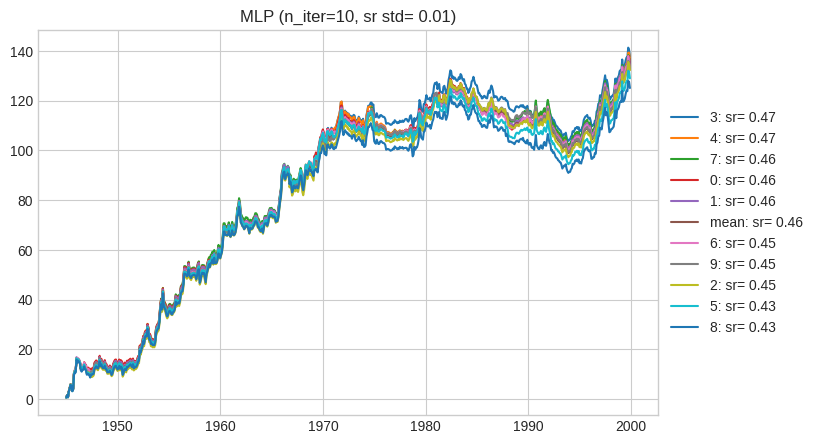

In [25]:
title = f"MLP (n_iter={n_iter}, sr std= {sr_std:.2f})"
line(
    pd.concat(pnls_, axis=1).assign(mean=lambda x: x.mean(axis=1)),
    cumsum=True,
    title=title,
)